# Tales of Tribute Deck Suggestions

*The Elder Scrolls Online's* __Tales of Tribute__ (ToT) is a deck-building card game added to the game with the *High Isle* Chapter. Each match starts with players taking turns choosing four decks, with thirty seconds for each choice. Player 1 chooses the first deck to start, followed by player 2 choosing the second and third decks. Player 1 then chooses the final deck. The combination of decks in a game can have a significant impact on the outcome. Most players are more comfortable with particular combinations and have an easier time winning with them, but might fail to notice if their favorites are weak when combined in specific ways. It's also important to make sure that there are multiple ways to win with the decks chosen for a match--some combinations come down to luck of the draw significantly more often than others, with fewer options for recovering once you fall behind.

----------
__Objective:__ analyze past ToT match outcomes and return information to inform deck selection at the start of future matches in a quick-to-read format.

----------

##### Import modules

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt

try:
    import gspread
    from gspread_dataframe import get_as_dataframe, set_with_dataframe

    print('using gspread & gspread_dataframe')
except ModuleNotFoundError:
    gspread = None
    get_as_dataframe = None
    set_with_dataframe = None

## Get matches

In [2]:
try:
    # import ToT match details from google sheets
    gc = gspread.service_account()
    # name of file in Google Sheets
    sh = gc.open('Tales of Tribute')
    # name of sheet in file
    df = get_as_dataframe(sh.worksheet('matches'))

except FileNotFoundError:
    print('INCOMPLETE GSPREAD SETUP: service_account.json not found. Check readme for link to instructions.')

except AttributeError:
    # replace mock_tribute.csv with location of csv or google sheets file
    df = pd.read_csv('mock_tribute.csv')

In [3]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes
0,2,tgronw4m,reach,pelin,hunding,psijic,w,Morbi vel lectus in quam fringilla rhoncus.
1,1,ggillbee1m,pelin,hlaalu,crow,hunding,w,In hac habitasse platea dictumst.
2,2,cdearman2p,pelin,hunding,reach,crow,l,NaN
3,1,mbolle3n,hunding,pelin,crow,hlaalu,w,NaN
4,1,mcuthbertson1t,hunding,psijic,hlaalu,pelin,w,"In est risus, auctor sed, tristique in, tempus..."


##### Deck names used:

In [4]:
# 'DECK NAME FROM CSV' : 'DECK'
# replace first value in each pair if deck names used in match log don't match second values
deck_names = {
    'black':'reach', 
    'blue':'psijic', 
    'green':'hunding', 
    'orange':'rajhin', 
    'orgnum':'orgnum', 
    'purple':'crow', 
    'red':'pelin', 
    'yellow':'hlaalu', 
    'druid':'druid'
    }

##### Clean data

In [5]:
# make sure column names are lowercase
df.columns = [x.lower() for x in df.columns]

# remove any rows with missing match info
df = df.dropna(subset=['p1 first', 'p2 first', 'p2 second', 'p1 second', 'result'])

# reset index
df.reset_index(inplace=True, drop=True)

# convert choice order column to integers
df['choice'] = df['choice'].apply(int)

# replace nan in notes column with empty strings
df['notes'] = df['notes'].replace(np.nan, '', regex=True)

In [6]:
# remove whitespace from decks + results & convert to lowercase
for col in df[['p1 first', 'p2 first', 'p2 second', 'p1 second', 'result']]:
    df[col] = df[col].str.strip().str.lower()

# remove whitespace from opponent names
df['opponent'] = df['opponent'].str.strip()

# replace deck names from spreadsheet with proper deck names
df = df.replace(deck_names)

In [7]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes
0,2,tgronw4m,reach,pelin,hunding,psijic,w,Morbi vel lectus in quam fringilla rhoncus.
1,1,ggillbee1m,pelin,hlaalu,crow,hunding,w,In hac habitasse platea dictumst.
2,2,cdearman2p,pelin,hunding,reach,crow,l,
3,1,mbolle3n,hunding,pelin,crow,hlaalu,w,
4,1,mcuthbertson1t,hunding,psijic,hlaalu,pelin,w,"In est risus, auctor sed, tristique in, tempus..."


###### Convert result column for calculating scores

In [8]:
# check unique values from the 'result' col
df.result.unique()

array(['w', 'l', 'c', 'dc'], dtype=object)

In [9]:
# match record values used
# results column values in df
win = 'w'
loss = 'l'
concede = 'c' # optional

# create new columns to hold number values for results of each match
df['won'] = 0
df['lost'] = 0

# split results column into either won or lost col
df.loc[df['result'] == win.lower(), 'won'] = 1
df.loc[df['result'] == loss.lower(), 'lost'] = 1
df.loc[df['result'] == concede.lower(), 'lost'] = 1

In [10]:
# check rows where neither 'won' or 'lost' were changed to 1
display(df[df['won'] + df['lost'] < 1])

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes,won,lost
49,1,tkornel4a,hunding,orgnum,crow,hlaalu,dc,Aenean fermentum. Donec ut mauris eget massa t...,0,0
51,1,bwhistance2z,hunding,psijic,rajhin,hlaalu,dc,,0,0
325,2,nmilesop23,crow,hunding,hlaalu,reach,dc,Praesent blandit. Nam nulla.,0,0
400,1,bstrute3z,pelin,rajhin,psijic,hlaalu,dc,In hac habitasse platea dictumst.,0,0
586,1,cdearman2p,pelin,rajhin,hlaalu,crow,dc,"In tempor, turpis nec euismod scelerisque, qua...",0,0
644,1,mcuthbertson1t,hunding,orgnum,crow,hlaalu,dc,,0,0
646,1,flettsom31,hunding,psijic,rajhin,hlaalu,dc,Nulla tempus.,0,0
920,2,tplevey3d,crow,hunding,hlaalu,reach,dc,Aenean lectus. Pellentesque eget nunc.,0,0
995,1,rboeckz,pelin,rajhin,psijic,hlaalu,dc,"Donec odio justo, sollicitudin ut, suscipit a,...",0,0


In [11]:
# sort decks in string alphabetically
def sort_decks(chosen_decks):

	# convert string to lowercase
	decks = chosen_decks.lower()
	# split string into individual decks
	decks = decks.split()

	# sort decks alphabetically
	decks.sort()

	# create empty string
	combined = ''

	for deck in range(len(decks)):
		combined = combined + decks[deck] + ' '

	# remove extra space at the end
	combined = combined.strip()
	return combined

In [12]:
df['decks'] = (
    df['p1 first']
    + ' '
    + df['p2 first']
    + ' '
    + df['p2 second']
    + ' '
    + df['p1 second']
)

# sort chosen decks values alphabetically
for match, decks in enumerate(df['decks']):
    df.at[match, 'decks'] = sort_decks(decks)

In [13]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes,won,lost,decks
0,2,tgronw4m,reach,pelin,hunding,psijic,w,Morbi vel lectus in quam fringilla rhoncus.,1,0,hunding pelin psijic reach
1,1,ggillbee1m,pelin,hlaalu,crow,hunding,w,In hac habitasse platea dictumst.,1,0,crow hlaalu hunding pelin
2,2,cdearman2p,pelin,hunding,reach,crow,l,,0,1,crow hunding pelin reach
3,1,mbolle3n,hunding,pelin,crow,hlaalu,w,,1,0,crow hlaalu hunding pelin
4,1,mcuthbertson1t,hunding,psijic,hlaalu,pelin,w,"In est risus, auctor sed, tristique in, tempus...",1,0,hlaalu hunding pelin psijic


##### Deck combination scores

In [14]:
scores = pd.concat((df.groupby('decks')['won'].sum(), df.groupby('decks')['lost'].sum()), axis=1)

# create column of total matches per deck combination
scores['total'] = scores['won'] + scores['lost']

# create column of % of matches that are wins per unique combination
scores['% wins'] = ((scores['won'] / scores['total']) * 100).round(decimals=1)

In [15]:
scores.head(5)

,won,lost,total,% wins
decks,,,,
crow druid hlaalu psijic,2,1,3,66.7
crow druid hlaalu reach,1,0,1,100.0
crow druid orgnum psijic,1,0,1,100.0
crow hlaalu hunding orgnum,16,4,20,80.0
crow hlaalu hunding pelin,79,34,113,69.9


###### Create dataframe of all possible deck combinations

In [16]:
# create list of all decks from deck_names values
all_decks = list(deck_names.values())

# create list of all unique combinations of 4 decks
combos = [' '.join(map(str, combo)) for combo in combinations(all_decks, 4)]

# convert list to dataframe
combos = pd.DataFrame(combos, columns=['decks'])

In [17]:
# sort chosen decks values alphabetically
for match, decks in enumerate(combos['decks']):
    combos.at[match, 'decks'] = sort_decks(decks)

# sort dataframe by 'decks' values, alphabetically
combos = combos.sort_values('decks')

###### Merge all combinations with match scores

In [18]:
# left merge scores dataframe onto combos
combos = combos.merge(
    scores, how='left', left_on='decks', right_index=True
)

# fill any blanks from unused combinations with 0s or blanks
combos.fillna({'won': 0, 'lost': 0, 'total': 0}, inplace=True)

In [19]:
combos.head(5)

,decks,won,lost,total,% wins
109,crow druid hlaalu hunding,0.0,0.0,0.0,NaN
123,crow druid hlaalu orgnum,0.0,0.0,0.0,NaN
125,crow druid hlaalu pelin,0.0,0.0,0.0,NaN
89,crow druid hlaalu psijic,2.0,1.0,3.0,66.7
119,crow druid hlaalu rajhin,0.0,0.0,0.0,NaN


In [20]:
combos_sh = combos.copy()

for row, decks in enumerate(combos_sh['decks']):
    deck_list = decks.split()
    combos_sh.at[row, 'a'] = deck_list[0]
    combos_sh.at[row, 'b'] = deck_list[1]
    combos_sh.at[row, 'c'] = deck_list[2]
    combos_sh.at[row, 'd'] = deck_list[3]

In [21]:
combos_sh = combos_sh[['a', 'b', 'c', 'd', 'won', 'lost', 'total', '% wins', 'decks']]
combos_sh.head(10)

,a,b,c,d,won,lost,total,% wins,decks
109,hlaalu,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu hunding
123,orgnum,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu orgnum
125,pelin,psijic,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu pelin
89,druid,pelin,rajhin,reach,2.0,1.0,3.0,66.7,crow druid hlaalu psijic
119,hunding,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu rajhin
54,crow,pelin,rajhin,reach,1.0,0.0,1.0,100.0,crow druid hlaalu reach
103,hlaalu,orgnum,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding orgnum
108,hlaalu,pelin,psijic,reach,0.0,0.0,0.0,NaN,crow druid hunding pelin
67,druid,hlaalu,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding psijic
97,hlaalu,hunding,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding rajhin


###### __Save scores to Google Sheets__

In [22]:
if set_with_dataframe != None:
    # set worksheet to save players to
    worksheet = sh.worksheet("scores")

    # save worksheet to Google Sheets
    set_with_dataframe(worksheet, combos_sh)
    print("scores worksheet updated")

else:
    print("Install gspread and gspread_dataframe to save 'scores' to Google Sheets file.")

Install gspread and gspread_dataframe to save 'scores' to Google Sheets file.


###### Individual deck performance

In [23]:
# find success rates for matches with each individual deck

single_decks = pd.DataFrame()

for deck in all_decks:
    # find all deck combinations containing an individual deck
    filtered = combos[combos['decks'].str.contains(deck, na=False)]

    # find the mean success rate with combinations including that deck
    single_decks.at[deck, '% wins'] = filtered['% wins'].mean()
    single_decks['% wins'] = single_decks['% wins'].round(decimals=2)

    # find total number of matches with deck
    single_decks.at[deck, 'total matches'] = filtered['total'].sum()

In [24]:
# create separate column for deck name
single_decks.reset_index(inplace=True)
single_decks = single_decks.rename(columns={'index':'decks'})
single_decks = single_decks[['decks', 'total matches', '% wins']]

In [25]:
# decks sorted chromatically
sorter = ['pelin', 'rajhin', 'hlaalu', 'druid', 'hunding', 'orgnum', 'psijic', 'crow', 'reach']

# convert deck column to category type using sorter list
single_decks.decks = single_decks.decks.astype('category')
single_decks.decks = single_decks.decks.cat.set_categories(sorter)

# sort df
single_decks = single_decks.sort_values('decks', ascending=True)

In [26]:
single_decks.head(5)

,decks,total matches,% wins
6,pelin,685.0,63.25
3,rajhin,235.0,49.37
7,hlaalu,808.0,57.20
8,druid,14.0,60.61
2,hunding,702.0,60.19


##### Deck combinations x3 (Player 1, 4th deck)

In [27]:
p2_choices = [' '.join(map(str, combo)) for combo in combinations(all_decks, 3)]

p2_choices = pd.DataFrame(p2_choices, columns=['decks'])

##### Deck combinations x2

In [28]:
npc_choices = [' '.join(map(str, combo)) for combo in combinations(all_decks, 2)]

npc_choices = pd.DataFrame(npc_choices, columns=['decks'])

##### Opponent deck choices

In [29]:
# create new columns
cols = ["op deck 1","op deck 2","choice 1","choice 2"]

for col in cols:
    df[col] = ''

# fill new columns based on choice order
for i, value in enumerate(df["choice"]):
    if value == 1:
        # fill new cols for matches as player 1
        df.at[i, "op deck 1"] = df.at[i, "p2 first"]
        df.at[i, "op deck 2"] = df.at[i, "p2 second"]
        df.at[i, "choice 1"] = df.at[i, "p1 first"]
        df.at[i, "choice 2"] = df.at[i, "p1 second"]

    elif value == 2:
        # fill new cols for matches as player 2
        df.at[i, "op deck 1"] = df.at[i, "p1 first"]
        df.at[i, "op deck 2"] = df.at[i, "p1 second"]
        df.at[i, "choice 1"] = df.at[i, "p2 first"]
        df.at[i, "choice 2"] = df.at[i, "p2 second"]

In [30]:
# filter dataframe for opposing player sheet
players = df[
    [
        "opponent",
        "op deck 1",
        "op deck 2",
        "choice 1",
        "choice 2",
        "won",
        "lost",
        "notes",
    ]
]

# sort matches by opponent username
players = players.sort_values(by="opponent", key=lambda col: col.str.lower())

# reset index
players.reset_index(drop=True, inplace=True)

In [31]:
players.head(3)

,opponent,op deck 1,op deck 2,choice 1,choice 2,won,lost,notes
0,abaxstare1o,crow,orgnum,hunding,hlaalu,1,0,Vivamus vel nulla eget eros elementum pellente...
1,abaxstare1o,hlaalu,crow,pelin,hunding,1,0,Praesent blandit lacinia erat. Vestibulum sed ...
2,abaxstare1o,reach,crow,hlaalu,rajhin,1,0,


In [32]:
if set_with_dataframe != None:
    # set worksheet to save players to
    worksheet = sh.worksheet("players")

    # save worksheet to Google Sheets
    set_with_dataframe(worksheet, players)
    print("players worksheet updated")

else:
    print("Install gspread and gspread_dataframe to save sorted 'players' dataframe in Google Sheets file.")

Install gspread and gspread_dataframe to save sorted 'players' dataframe in Google Sheets file.


##### Functions for deck choice graphs

In [33]:
# deck colors
plot_colors = {
    'pelin': '#E05353', #7C211D',
    'rajhin': '#E06E4E', #B54824',
    'hlaalu': '#F7B967', #E29836',
    'druid': '#acbf40', #A7BC31',
    'hunding': '#77A86B', #417238',
    'orgnum': '#66c3cc', #51B2BC',
    'psijic': '#80A2ED', #4C6BB5',
    'crow': '#9B6ED1', #5D3291',
    'reach': '#66605E' #33302F'
    }

# black/gray
neutral = '#313639'

# value at end of each bar
bar_text = {'va':'center', 'ha':'left', 'size':10}

plt.style.use("seaborn-white")
plt.rcParams["text.color"] = neutral
plt.rcParams["xtick.labelcolor"] = neutral
plt.rcParams["ytick.labelcolor"] = neutral

In [34]:
# create a graph of deck choices
def choice_graph(x, y, colors, title, choices):

    # get rid of decimals
    tb_cols = choices.columns
    tb_cols = [x for x in tb_cols if not x.startswith('deck')]
    for col in tb_cols:
        choices[col] = choices[col].round(decimals=0).astype(int)
    
    # x-axis limit
    width = choices['% wins'].max() + 10

    # adjust graph size based on number of decks to choose from
    graph_length = (len(x) / 4) + 2

    fig, ax =plt.subplots(figsize=(6,graph_length), dpi=100)

    x = x[::-1]
    y = y[::-1]
    if type(colors) is list:
        colors.reverse()

    ax.set_title(title)
    ax.barh(x, y, color=colors)
    ax.set_xlim(0, width)

    plt.xticks([]) 
    plt.yticks([]) 

    for index, label in enumerate(x):
        plt.text(2, (index-0.05), str(label), c='w', weight='semibold', **bar_text)

    for index, value in enumerate(y):
        plt.text((value + 1), (index-0.05), str('{:.0f}%'.format(value)), **bar_text)

    if 'deck a' in choices.columns:
        choices = choices.drop(columns=['decks'])

    #create table
    table = plt.table(cellText=choices.values, colLabels=choices.columns, loc='bottom', cellLoc='center')

    for cell in table.get_children():
        cell_text = cell.get_text().get_text()
        cell.set_edgecolor(neutral)
        if cell_text in choices.columns:
            cell.get_text().set_color('w')
            cell.set_facecolor('#a7bebe')
        elif cell_text in plot_colors:
            cell.set_facecolor(plot_colors[cell_text])
            cell.get_text().set_color('w')
            cell.get_text().set_weight('semibold')
        else:
            cell.get_text().set_color(neutral)

    table.scale(1, 1.5)

    #fig.savefig("images/p1_first.png", bbox_inches="tight")
    #fig.savefig("images/p2.png", bbox_inches="tight")
    #fig.savefig("images/p1_fourth.png", bbox_inches="tight")


In [35]:
# find combinations containing each listed deck
def filter_combos(df, *decks):

    filtered = df.copy()

    for deck in decks:
        if deck not in deck_names.values() and deck in deck_names:
            deck = deck_names[deck]

        # find combinations containing selected decks
        filtered = filtered[filtered["decks"].str.contains(deck, na=False)]
        filtered.replace(deck, "", inplace=True, regex=True)

    filtered["decks"] = filtered["decks"].str.strip()

    # remove combinations that haven't been used yet (NaN in % wins col)
    filtered = filtered.dropna()

    # reset index
    filtered.reset_index(inplace=True, drop=True)
    return filtered

In [36]:
def choose_deck(*chosen_decks):

    chosen_decks = [i for i in chosen_decks if i]

    # if three decks were entered, return choices for final deck
    if len(chosen_decks) == 3:
        
        choices = combos.copy()

        for chosen_deck in chosen_decks:
            choices = filter_combos(choices, chosen_deck)

        x = choices['decks']
        y = choices['% wins']
        colors = [plot_colors[key] for key in x]
        title = f'tales of tribute: final choice ({chosen_decks[0]}, {chosen_decks[1]}, {chosen_decks[2]})'

    # if one deck was entered, find best choices for second and third decks
    elif len(chosen_decks) == 1:

        choices = filter_combos(p2_choices, chosen_decks[0])

        for row, deck_pairs in enumerate(choices['decks']):
            deck_pairs = deck_pairs.split()
            choices.at[row, 'deck a'] = deck_pairs[0]
            choices.at[row, 'deck b'] = deck_pairs[1]

            choices_score = filter_combos(combos, chosen_decks[0], deck_pairs[0], deck_pairs[1])

            choices.at[row, 'total'] = choices_score['total'].sum()

            # 6 total combinations possible per pair
            # subtract length of combinations found to find # of untested
            untested = (6 - len(choices_score.index))

            score = choices_score['% wins'].sum()

            choices.at[row, 'untested'] = untested

            if untested == 6:
                choices.at[row, '% wins'] = 0

            elif score == 0:
                choices.at[row, '% wins'] = 0

            else:
                choices.at[row, '% wins'] = (score / (6 - untested)).round(decimals=1)

        # sort with lowest untested values at top, and values with the same untested value sorted by % wins
        choices = choices.sort_values(['untested','% wins'], ascending=[True, False]).reset_index(drop=True)
        # only keep top 10 choices
        choices = choices.head(10)

        x = choices['decks']
        y = choices['% wins']
        if chosen_decks[0] not in plot_colors and chosen_decks[0] in deck_names:
            colors = plot_colors[deck_names[chosen_decks[0]]]
        else:
            colors = plot_colors[chosen_decks[0]]
        title = f'tales of tribute: player 2 deck choices ({chosen_decks[0]})'

    # if no decks were entered, show performance of individual decks
    else:
        choices = single_decks
        x = choices['decks']
        y = choices['% wins']
        colors = [plot_colors[key] for key in x]
        title = 'tales of tribute: first deck choice'

    choice_graph(x, y, colors, title, choices)

In [37]:
# use plot_colors dict for cell background in dataframe
def color_chart(deck):
    if deck in all_decks:
        color = plot_colors[deck]
        return 'background-color: %s' % color

def opp_prefs(username):
    # past choices by opposing player, for possible player 1 fourth choices
    prefs = players[players["opponent"] == username]

    prefs = prefs.sort_values(['lost', 'won'])
    
    # center text, color code deck cells
    return prefs.style.applymap(color_chart).set_properties(**{'text-align':'center'}).format(precision=0, na_rep='n/a')

#### __Player 1: First Deck__ 

With no decks entered, the returned bar graph shows how often past matches containing each deck were won to help with first deck choice as Player 1.

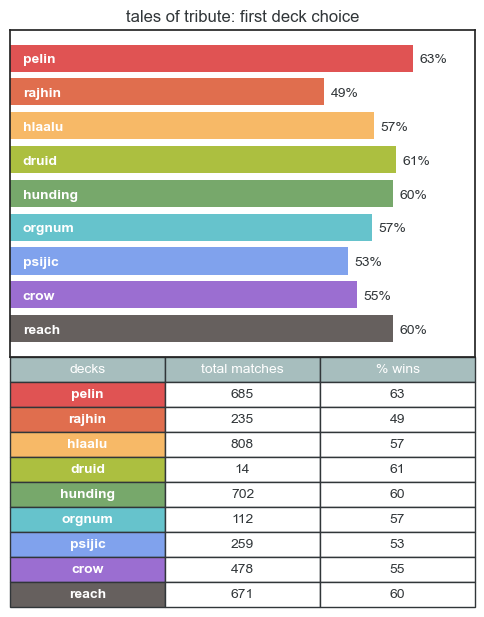

In [38]:
# player 1, first deck
choose_deck()

*__Best deck choice shown:__ Saint Pelin (red)*

#### __Player 2: Second and Third Decks__

Entering only one deck returns a bar graph with pairs of choices. Combinations with Player 1's selected deck + one of the possible remaining deck option pairs are averaged, leaving out any combinations that haven't been seen yet in a match. __Choices are ranked first by the deck pairs with the fewest untested combinations, then by the averaged win rate for each pair.__

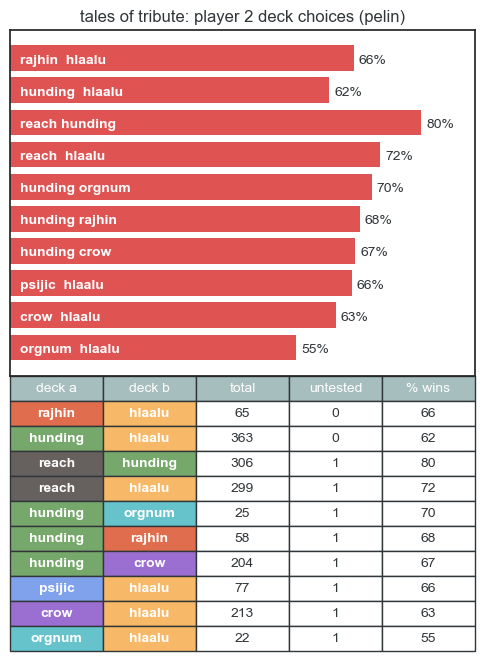

In [39]:
# player 2, second and third decks
choose_deck('pelin')

*__Best deck choice shown:__ The Reach (black) + Ansei Hunding (green)*

#### __Player 1: Fourth Deck__

After Player 1's first deck choice and the pair of decks chosen by Player 2 are entered, the bar graph shows the win rate of matches containing the selected decks plus each of the remaining choices to help select the final deck for the match.

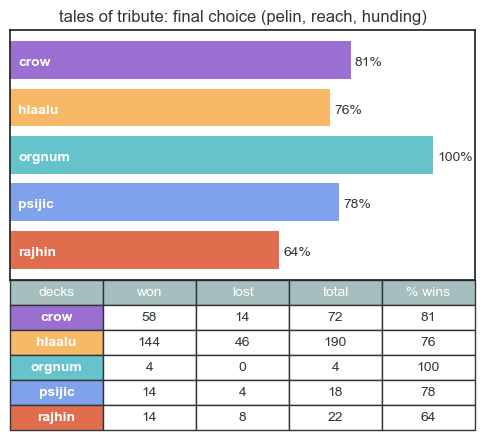

In [40]:
# player 1, fourth deck
choose_deck('pelin', 'reach', 'hunding')

*__Best deck choice shown:__ King Orgnum (teal)*

#### __Past matches with opponent__

If it isn't your first match playing against a specific opponent, checking the choices and results of past matches might improve your chances of winning. As Player 2, it offers a better guess for what they might choose for the fourth deck (assuming they have a clear pattern). As Player 1, it can show if you've consistently won matches against them with a slightly weaked deck combination.

In [41]:
# all matches against player, sorted by result
opp_prefs('abeagleyu')

,opponent,op deck 1,op deck 2,choice 1,choice 2,won,lost,notes
3,abeagleyu,hlaalu,hunding,pelin,reach,1,0,Nulla facilisi.
4,abeagleyu,hlaalu,reach,pelin,hunding,1,0,
5,abeagleyu,reach,psijic,hunding,hlaalu,1,0,
6,abeagleyu,reach,hunding,pelin,hlaalu,1,0,Nunc nisl.
7,abeagleyu,reach,crow,rajhin,hlaalu,0,1,Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia Curae; Mauris viverra diam vitae quam. Suspendisse potenti.
8,abeagleyu,crow,pelin,hunding,hlaalu,0,1,


If 'abeagleyu' was player 2 in the above examples, player 1 might have been better off choosing Grandmaster Hlaalu for the fourth deck since 'abeagleyu' lost every match with those four decks.

---

## Match Suggestions

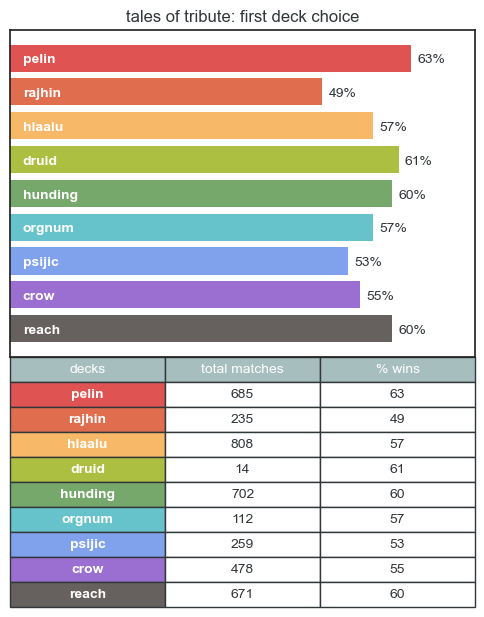

In [42]:
# enter each deck selected for match in quotation marks
# separate with a comma outside of the quotation marks
choose_deck('')

In [43]:
# enter username inside quotation marks
opp_prefs('')

,opponent,op deck 1,op deck 2,choice 1,choice 2,won,lost,notes
